Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Starting Epoch 1
Epoch 1, Batch 100, Loss: 1.6911
Epoch 1, Batch 200, Loss: 1.3324
Epoch 1, Batch 300, Loss: 1.2047
Starting Epoch 2
Epoch 2, Batch 100, Loss: 1.0347
Epoch 2, Batch 200, Loss: 0.9797
Epoch 2, Batch 300, Loss: 0.9498
Starting Epoch 3
Epoch 3, Batch 100, Loss: 0.8423
Epoch 3, Batch 200, Loss: 0.8218
Epoch 3, Batch 300, Loss: 0.8282
Starting Epoch 4
Epoch 4, Batch 100, Loss: 0.6940
Epoch 4, Batch 200, Loss: 0.7062
Epoch 4, Batch 300, Loss: 0.6923
Starting Epoch 5
Epoch 5, Batch 100, Loss: 0.5833
Epoch 5, Batch 200, Loss: 0.5929
Epoch 5, Batch 300, Loss: 0.6067
Starting Epoch 6
Epoch 6, Batch 100, Loss: 0.4769
Epoch 6, Batch 200, Loss: 0.5017
Epoch 6, Batch 300, Loss: 0.4867
Starting Epoch 7
Epoch 7, Batch 100, Loss: 0.3685
Epoch 7, Batch 200, Loss: 0.3743
Epoch 7, Batch 300, Loss: 0.3960
Starting Epoch 8
Epoch 8, Batch 100, Loss: 0.2707
Epoch 8, Batch 200, Loss: 0.2759
Epoch 8, B

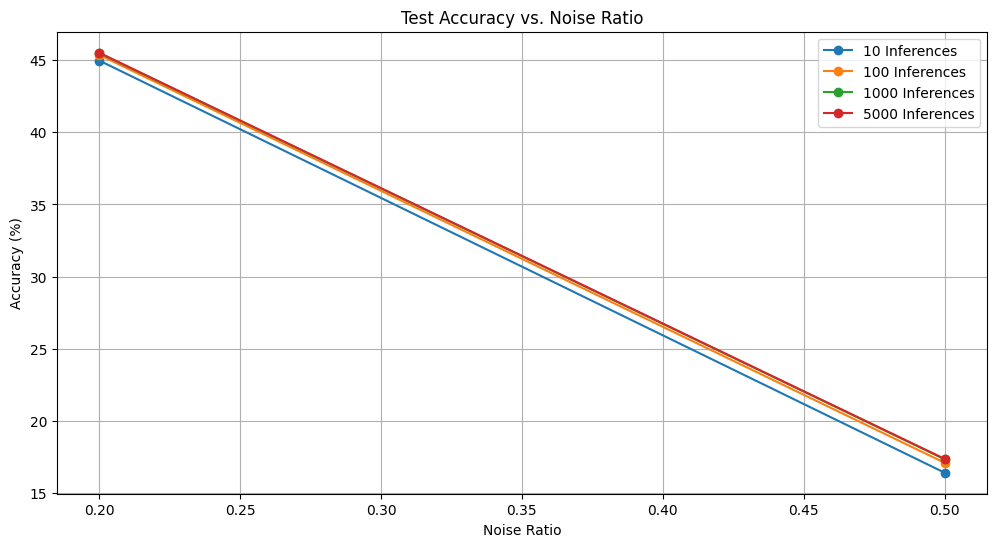

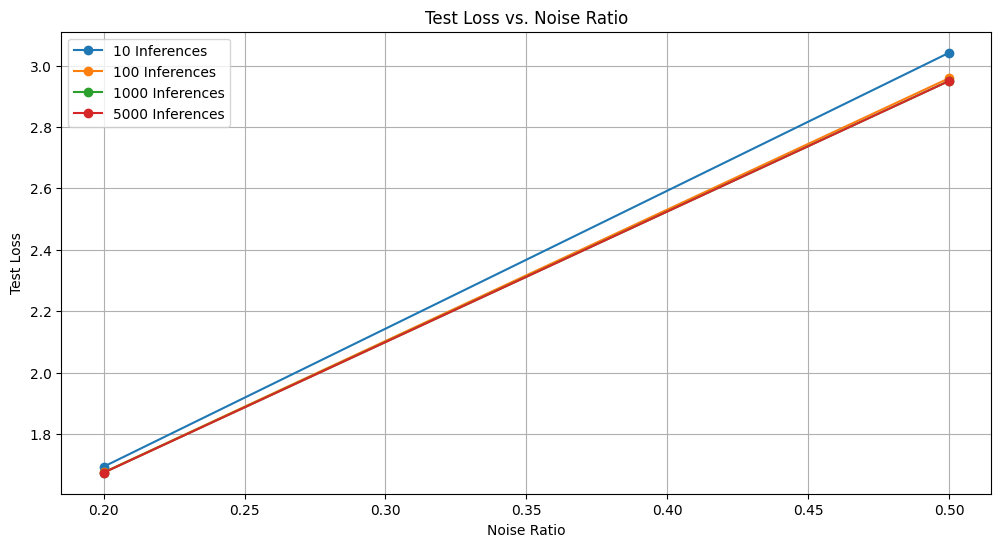

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to inject uniform noise into a tensor
def inject_noise(x, noise_ratio, activation_range):
    noise_scale = noise_ratio * (activation_range[1] - activation_range[0])
    noise = torch.empty_like(x).uniform_(-noise_scale, noise_scale)
    return x + noise

# Define the CNN model
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()

        # Define the network layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward_once(self, x, noise_ratio=0.0):
        # First convolutional layer + ReLU + optional noise
        x = F.relu(self.conv1(x))
        if noise_ratio > 0.0:
            x = inject_noise(x, noise_ratio, activation_range=(0, 1))  # ReLU activation

        # First pooling layer
        x = self.pool(x)

        # Second convolutional layer + ReLU + optional noise
        x = F.relu(self.conv2(x))
        if noise_ratio > 0.0:
            x = inject_noise(x, noise_ratio, activation_range=(0, 1))  # ReLU

        # Second pooling layer (added)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layer + Tanh + optional noise
        x = torch.tanh(self.fc1(x))
        if noise_ratio > 0.0:
            x = inject_noise(x, noise_ratio, activation_range=(-1, 1))  # Tanh activation

        # Output layer
        x = self.fc2(x)
        return x

    def forward(self, x, num_inferences=1, noise_ratio=0.0):
        if num_inferences > 1:
            # Perform multiple forward passes with noise, collect outputs
            outputs = []
            for _ in range(num_inferences):
                out = self.forward_once(x, noise_ratio=noise_ratio)
                outputs.append(out.unsqueeze(0))
            # Stack and average
            outputs = torch.cat(outputs, dim=0)
            avg_output = torch.mean(outputs, dim=0)
            return avg_output
        else:
            # Single forward pass
            return self.forward_once(x, noise_ratio=noise_ratio)

# ... (rest of the code remains the same)


# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training and testing datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define DataLoaders with consistent batch sizes
batch_size = 128  # Consistent batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = CIFAR10_CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, device, train_loader, optimizer, criterion, epoch):
    """
    Trains the model for one epoch.

    Parameters:
    - model (nn.Module): The neural network model.
    - device (torch.device): The device to run computations on.
    - train_loader (DataLoader): DataLoader for training data.
    - optimizer (Optimizer): Optimizer for updating model weights.
    - criterion (Loss): Loss function.
    - epoch (int): Current epoch number.
    """
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward pass without noise
        outputs = model(data)

        # Compute loss
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        if batch_idx % 100 == 99:  # Print every 100 batches
            avg_loss = running_loss / 100
            print(f"Epoch {epoch}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0

# Function to evaluate the model with varying noise and inference counts
def evaluate_model(model, device, test_loader, criterion, noise_levels, inference_counts):
    """
    Evaluates the model on the test dataset with different noise levels and inference counts.

    Parameters:
    - model (nn.Module): The trained neural network model.
    - device (torch.device): The device to run computations on.
    - test_loader (DataLoader): DataLoader for testing data.
    - criterion (Loss): Loss function.
    - noise_levels (list of float): List of noise ratios to evaluate.
    - inference_counts (list of int): List of numbers of inferences to average.

    Returns:
    - results (dict): Dictionary containing test accuracy and loss for each combination.
    """
    model.eval()
    results = {}
    with torch.no_grad():
        for noise_ratio in noise_levels:
            for num_inferences in inference_counts:
                test_loss = 0.0
                correct = 0
                total = 0
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    # Perform forward pass with noise and averaging
                    outputs = model(data, num_inferences=num_inferences, noise_ratio=noise_ratio)

                    # Compute loss
                    loss = criterion(outputs, target)
                    test_loss += loss.item() * data.size(0)  # Accumulate loss

                    # Compute accuracy
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == target).sum().item()
                    total += target.size(0)

                avg_loss = test_loss / total
                accuracy = 100. * correct / total
                results[(noise_ratio, num_inferences)] = {'loss': avg_loss, 'accuracy': accuracy}
                print(f"Noise Ratio: {noise_ratio}, Num Inferences: {num_inferences}, "
                      f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return results

# Train the model for 10 epochs without noise
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    print(f"Starting Epoch {epoch}")
    train(model, device, train_loader, optimizer, criterion, epoch)

# Define noise levels and inference counts to test
noise_levels = [0.2, 0.5]
inference_counts = [10, 100, 1000, 5000]

# Evaluate the model with varying noise levels and inference counts
results = evaluate_model(model, device, test_loader, criterion, noise_levels, inference_counts)

# Visualize the results
import matplotlib.pyplot as plt

# Prepare data for visualization
import pandas as pd

# Convert results dictionary to a DataFrame
data = []
for (noise_ratio, num_inferences), metrics in results.items():
    data.append({
        'Noise Ratio': noise_ratio,
        'Num Inferences': num_inferences,
        'Test Loss': metrics['loss'],
        'Accuracy': metrics['accuracy']
    })
df = pd.DataFrame(data)

# Plot Accuracy vs. Noise Ratio for different numbers of inferences
plt.figure(figsize=(12, 6))
for num_inferences in inference_counts:
    subset = df[df['Num Inferences'] == num_inferences]
    plt.plot(subset['Noise Ratio'], subset['Accuracy'], marker='o', label=f'{num_inferences} Inferences')
plt.title('Test Accuracy vs. Noise Ratio')
plt.xlabel('Noise Ratio')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Loss vs. Noise Ratio for different numbers of inferences
plt.figure(figsize=(12, 6))
for num_inferences in inference_counts:
    subset = df[df['Num Inferences'] == num_inferences]
    plt.plot(subset['Noise Ratio'], subset['Test Loss'], marker='o', label=f'{num_inferences} Inferences')
plt.title('Test Loss vs. Noise Ratio')
plt.xlabel('Noise Ratio')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()
